In [ ]:
# Install necessary packages
import os
import ee
import geemap
!pip install xee matplotlib numpy pandas seaborn
import xee
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [ ]:
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(
    project = 'gee-project-436010',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)
print("Earth Engine initialized successfully!")

In [ ]:
# Create a map centered on Finland
map = geemap.Map(center=[64.5, 26], zoom=5)
display(map)

# Define Finland's boundary
finland = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na', 'Finland'))
finland_geo = finland.geometry()

# Add Finland to the map
map.addLayer(finland_geo, {'color': 'blue'}, 'Finland')
map.centerObject(finland_geo, 6)

# Calculate Finland's area in square kilometers
finland_area_m2 = finland.geometry().area()
finland_area_km2 = ee.Number(finland_area_m2).divide(1e6)
print(f"Finland's area: {finland_area_km2.getInfo()} km²")

Map(center=[64.5, 26], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

Finland's area: 332237.085753524 km²



Loading GRACE data...
Number of GRACE images available: 238
Available data period: 2002-04-03 to 2024-09-30

Extracting time series data for Finland (this may take 30-60 seconds)...
Successfully extracted 238 data points

Data preview:
        date    twsa_cm        time_ms
0 2002-04-03   0.055535  1017792000000
1 2002-05-01  -3.072898  1020211200000
2 2002-07-31  -6.513667  1028073600000
3 2002-08-31  -9.808528  1030752000000
4 2002-09-30 -12.661440  1033344000000

Data statistics:
count    238.000000
mean       0.961399
std        5.313661
min      -12.774193
25%       -2.782772
50%        0.608276
75%        4.450926
max       15.386979
Name: twsa_cm, dtype: float64

LINEAR REGRESSION RESULTS
Slope: 0.00102308 cm/day
Intercept: -3.1739 cm
R-squared: 0.2259
P-value: 8.106437e-15
Standard Error: 0.00012327

WATER STORAGE CHANGE IN FINLAND
Rate: 0.3737 cm/year
Volume change: 1.24e+09 cubic meters per year
Mass change: 1.2415 gigatons per year

🔵 Finland is GAINING approximately 1.2415

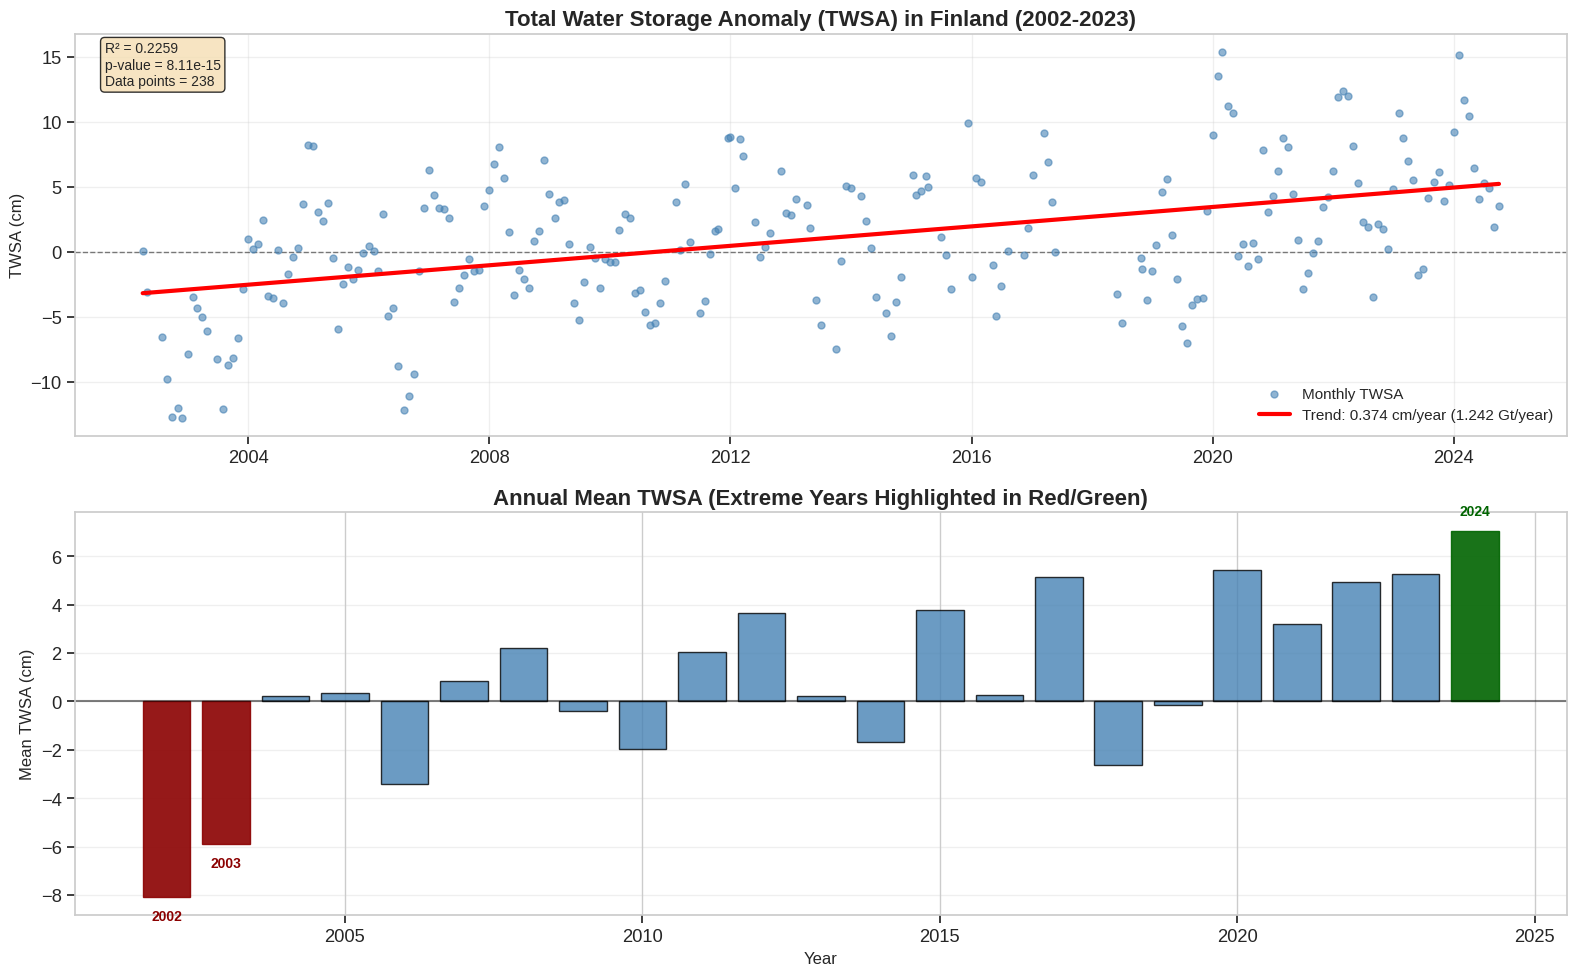

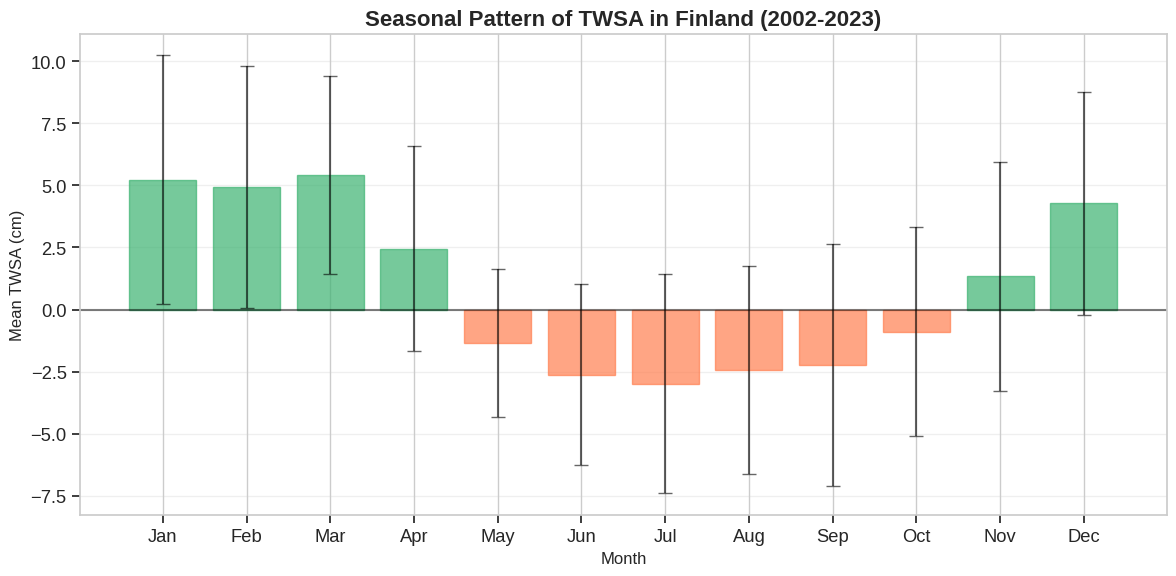

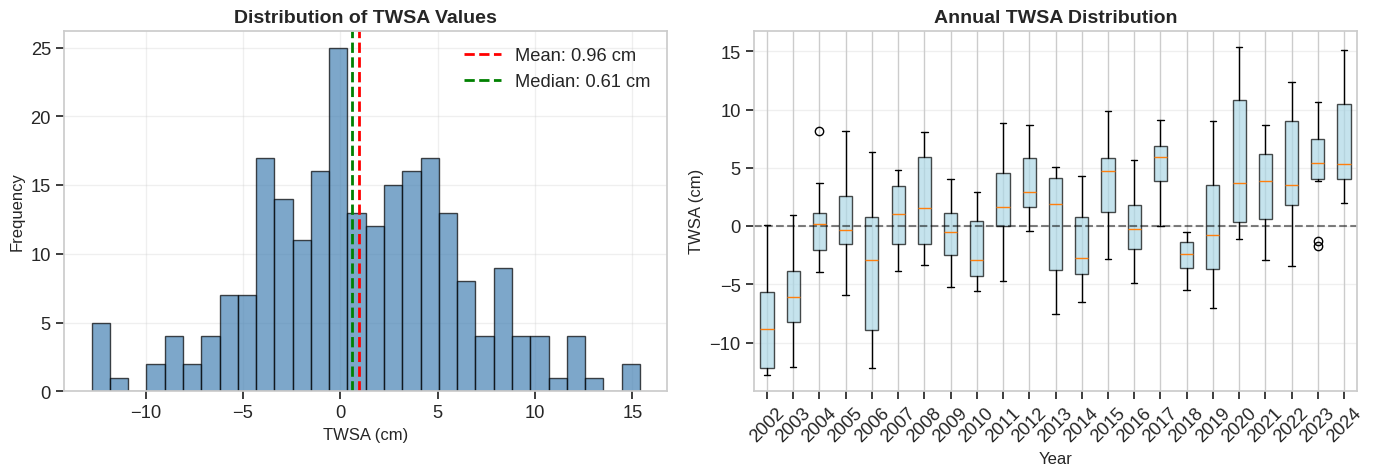


SUMMARY OF FINDINGS

1. WATER STORAGE TREND:
   Finland is GAINING approximately 1.2415 gigatons of water per year
   This corresponds to 0.3737 cm/year change in water equivalent thickness

2. EXTREME YEARS:
   Extreme years identified (z-score > 1.5): 2002, 2003, 2024
   - 2002: dry year with mean TWSA of -8.08 cm
   - 2003: dry year with mean TWSA of -5.88 cm
   - 2024: wet year with mean TWSA of 7.05 cm

3. RECORD YEARS:
   Wettest year: 2024 (mean TWSA: 7.05 cm)
   Driest year: 2002 (mean TWSA: -8.08 cm)

4. SEASONAL PATTERN:
   Highest TWSA typically in: Mar (5.42 cm)
   Lowest TWSA typically in: Jul (-2.99 cm)

5. DATA QUALITY:
   Total observations: 238
   Time span: 22.5 years
   Regression R²: 0.2259 (trend explains 22.6% of variance)

Analysis complete! All figures have been saved.


In [ ]:
# GRACE Total Water Storage Anomaly Analysis for Finland
# Load GRACE data
print("\nLoading GRACE data...")
grace = (
    ee.ImageCollection("NASA/GRACE/MASS_GRIDS_V04/MASCON")
    .filterDate('2002-04-01', '2025-10-01')  # Use all available GRACE data
    .select('lwe_thickness')
    .filterBounds(finland_geo)
)

# Get the number of images
num_images = grace.size().getInfo()
print(f"Number of GRACE images available: {num_images}")

# Get date range - FIXED VERSION
dates_list = grace.aggregate_array('system:time_start').getInfo()  # Convert to Python list first
if dates_list:
    first_date = pd.to_datetime(min(dates_list), unit='ms')
    last_date = pd.to_datetime(max(dates_list), unit='ms')
    print(f"Available data period: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
else:
    print("No data available for the selected period!")

# Function to extract mean TWSA for each image
def extract_mean_twsa(image):
    """Extract mean TWSA value over Finland for a single image"""
    # Calculate mean value over Finland
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=finland_geo,
        scale=25000,  # 25km scale appropriate for GRACE resolution
        maxPixels=1e9
    )

    # Get the date
    date = image.date().format('YYYY-MM-dd')

    return ee.Feature(None, {
        'date': date,
        'twsa_cm': mean_dict.get('lwe_thickness'),
        'time_ms': image.date().millis()
    })

# Extract time series data
print("\nExtracting time series data for Finland (this may take 30-60 seconds)...")
time_series = grace.map(extract_mean_twsa)

# Convert to a list and then to pandas DataFrame
ts_list = time_series.reduceColumns(ee.Reducer.toList(3), ['date', 'twsa_cm', 'time_ms']).values().get(0).getInfo()

# Create DataFrame
df_finland = pd.DataFrame(ts_list, columns=['date', 'twsa_cm', 'time_ms'])
df_finland['date'] = pd.to_datetime(df_finland['date'])
df_finland = df_finland.sort_values('date').reset_index(drop=True)

# Remove any NaN values
df_finland = df_finland.dropna(subset=['twsa_cm'])

print(f"Successfully extracted {len(df_finland)} data points")
print(f"\nData preview:")
print(df_finland.head())
print(f"\nData statistics:")
print(df_finland['twsa_cm'].describe())

# Add additional time components for analysis
df_finland['year'] = df_finland['date'].dt.year
df_finland['month'] = df_finland['date'].dt.month
df_finland['day'] = df_finland['date'].dt.day

# Calculate linear regression for trend analysis
# Create a continuous time variable (days since start)
start_date = df_finland['date'].min()
df_finland['days'] = (df_finland['date'] - start_date).dt.days

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_finland['days'], df_finland['twsa_cm'])

print(f"\n{'='*60}")
print(f"LINEAR REGRESSION RESULTS")
print(f"{'='*60}")
print(f"Slope: {slope:.8f} cm/day")
print(f"Intercept: {intercept:.4f} cm")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.6e}")
print(f"Standard Error: {std_err:.8f}")

# Convert slope from cm/day to cm/year and then to gigatons/year
cm_per_year = slope * 365.25

# Get the area as a Python number
finland_area_m2_value = finland_area_m2.getInfo()

# 1 cm over Finland's area equals:
# 1 cm = 0.01 m of water depth
# Volume = depth × area
# 1 cubic meter of water = 1 metric ton
# 1 gigaton = 1 billion metric tons
cubic_meters_per_year = (cm_per_year / 100) * finland_area_m2_value  # Convert cm to m
tons_per_year = cubic_meters_per_year  # 1 cubic meter of water = 1 metric ton
gigatons_per_year = tons_per_year / 1e9

print(f"\n{'='*60}")
print(f"WATER STORAGE CHANGE IN FINLAND")
print(f"{'='*60}")
print(f"Rate: {cm_per_year:.4f} cm/year")
print(f"Volume change: {cubic_meters_per_year:.2e} cubic meters per year")
print(f"Mass change: {gigatons_per_year:.4f} gigatons per year")

if gigatons_per_year > 0:
    print(f"\n🔵 Finland is GAINING approximately {abs(gigatons_per_year):.4f} gigatons of water per year")
else:
    print(f"\n🔴 Finland is LOSING approximately {abs(gigatons_per_year):.4f} gigatons of water per year")

# Calculate annual statistics
def calculate_annual_stats(df):
    """Calculate annual mean, min, max TWSA values"""
    annual_stats = df.groupby('year').agg(
        mean_twsa=('twsa_cm', 'mean'),
        min_twsa=('twsa_cm', 'min'),
        max_twsa=('twsa_cm', 'max'),
        std_twsa=('twsa_cm', 'std'),
        count=('twsa_cm', 'count')
    ).reset_index()

    # Calculate z-scores to identify extreme years
    annual_stats['mean_z_score'] = (annual_stats['mean_twsa'] - annual_stats['mean_twsa'].mean()) / annual_stats['mean_twsa'].std()

    return annual_stats

annual_stats = calculate_annual_stats(df_finland)

print(f"\n{'='*60}")
print(f"ANNUAL STATISTICS")
print(f"{'='*60}")
print(annual_stats.to_string(index=False))

# Identify extreme years (z-score > 1.5 or < -1.5)
extreme_threshold = 1.5
extreme_years = annual_stats[abs(annual_stats['mean_z_score']) > extreme_threshold]

print(f"\n{'='*60}")
print(f"EXTREME YEARS (z-score > {extreme_threshold} or < -{extreme_threshold})")
print(f"{'='*60}")
if len(extreme_years) > 0:
    for _, row in extreme_years.iterrows():
        condition = "EXTREMELY WET" if row['mean_z_score'] > 0 else "EXTREMELY DRY"
        print(f"Year {int(row['year'])}: {condition}")
        print(f"  - Z-score: {row['mean_z_score']:.2f}")
        print(f"  - Mean TWSA: {row['mean_twsa']:.2f} cm")
        print(f"  - Standard deviation: {row['std_twsa']:.2f} cm")
        print()
else:
    print("No extreme years detected with the current threshold.")
    print("Let's check with a lower threshold (z-score > 1.0):")
    moderate_extremes = annual_stats[abs(annual_stats['mean_z_score']) > 1.0]
    if len(moderate_extremes) > 0:
        for _, row in moderate_extremes.iterrows():
            condition = "Wet" if row['mean_z_score'] > 0 else "Dry"
            print(f"{int(row['year'])}: {condition} (z-score: {row['mean_z_score']:.2f})")

# Find max and min years
max_year = annual_stats.loc[annual_stats['mean_twsa'].idxmax()]
min_year = annual_stats.loc[annual_stats['mean_twsa'].idxmin()]

print(f"\n{'='*60}")
print(f"RECORD YEARS")
print(f"{'='*60}")
print(f"🌊 Wettest year: {int(max_year['year'])} (mean TWSA: {max_year['mean_twsa']:.2f} cm)")
print(f"🏜️  Driest year: {int(min_year['year'])} (mean TWSA: {min_year['mean_twsa']:.2f} cm)")
print(f"Difference: {max_year['mean_twsa'] - min_year['mean_twsa']:.2f} cm")

# ============================================================================
# PLOTTING
# ============================================================================

# Figure 1: Time series with trend line
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Time series with trend line
ax1 = axes[0]
ax1.scatter(df_finland['date'], df_finland['twsa_cm'], alpha=0.6, s=25, color='steelblue', label='Monthly TWSA', zorder=3)

# Add trend line
trend_dates = pd.date_range(start=df_finland['date'].min(), end=df_finland['date'].max(), periods=100)
trend_days = [(d - start_date).days for d in trend_dates]
trend_values = [intercept + slope * d for d in trend_days]
ax1.plot(trend_dates, trend_values, 'r-', linewidth=3,
         label=f'Trend: {cm_per_year:.3f} cm/year ({gigatons_per_year:.3f} Gt/year)', zorder=4)

# Add zero line
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1, zorder=2)

ax1.set_title('Total Water Storage Anomaly (TWSA) in Finland (2002-2023)', fontsize=16, fontweight='bold')
ax1.set_ylabel('TWSA (cm)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11, loc='best')

# Add text box with statistics
textstr = f'R² = {r_value**2:.4f}\np-value = {p_value:.2e}\nData points = {len(df_finland)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Subplot 2: Annual means with extreme years highlighted
ax2 = axes[1]
bars = ax2.bar(annual_stats['year'], annual_stats['mean_twsa'], alpha=0.8, color='steelblue', edgecolor='black')

# Highlight extreme years
for i, year in enumerate(annual_stats['year']):
    if abs(annual_stats.loc[i, 'mean_z_score']) > extreme_threshold:
        color = 'darkred' if annual_stats.loc[i, 'mean_z_score'] < 0 else 'darkgreen'
        bars[i].set_color(color)
        bars[i].set_alpha(0.9)
        # Add label
        y_pos = annual_stats.loc[i, 'mean_twsa']
        offset = 0.5 if y_pos > 0 else -0.5
        ax2.text(year, y_pos + offset, f'{int(year)}',
                 ha='center', va='bottom' if y_pos > 0 else 'top',
                 fontweight='bold', fontsize=10, color=color)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax2.set_title('Annual Mean TWSA (Extreme Years Highlighted in Red/Green)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Mean TWSA (cm)', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('finland_twsa_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Seasonal patterns
monthly_means = df_finland.groupby('month')['twsa_cm'].mean().reset_index()
monthly_std = df_finland.groupby('month')['twsa_cm'].std().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bars = ax.bar(monthly_means['month'], monthly_means['twsa_cm'], color='teal', alpha=0.7, edgecolor='black')
ax.errorbar(monthly_means['month'], monthly_means['twsa_cm'], yerr=monthly_std['twsa_cm'],
            fmt='none', ecolor='black', capsize=5, alpha=0.6)

# Color bars based on value
for i, bar in enumerate(bars):
    if monthly_means.loc[i, 'twsa_cm'] > 0:
        bar.set_color('mediumseagreen')
    else:
        bar.set_color('coral')

ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax.set_title('Seasonal Pattern of TWSA in Finland (2002-2023)', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Mean TWSA (cm)', fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('finland_twsa_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Distribution and box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(df_finland['twsa_cm'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(df_finland['twsa_cm'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_finland["twsa_cm"].mean():.2f} cm')
ax1.axvline(df_finland['twsa_cm'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_finland["twsa_cm"].median():.2f} cm')
ax1.set_xlabel('TWSA (cm)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of TWSA Values', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot by year
ax2 = axes[1]
annual_data = [df_finland[df_finland['year'] == year]['twsa_cm'].values for year in sorted(df_finland['year'].unique())]
bp = ax2.boxplot(annual_data, labels=sorted(df_finland['year'].unique()), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('TWSA (cm)', fontsize=12)
ax2.set_title('Annual TWSA Distribution', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('finland_twsa_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'='*60}")
print(f"SUMMARY OF FINDINGS")
print(f"{'='*60}")
print(f"\n1. WATER STORAGE TREND:")
print(f"   Finland is {'GAINING' if gigatons_per_year > 0 else 'LOSING'} approximately {abs(gigatons_per_year):.4f} gigatons of water per year")
print(f"   This corresponds to {cm_per_year:.4f} cm/year change in water equivalent thickness")

print(f"\n2. EXTREME YEARS:")
if len(extreme_years) > 0:
    extreme_years_list = [str(int(year)) for year in extreme_years['year']]
    print(f"   Extreme years identified (z-score > {extreme_threshold}): {', '.join(extreme_years_list)}")
    for _, row in extreme_years.iterrows():
        condition = "wet" if row['mean_z_score'] > 0 else "dry"
        print(f"   - {int(row['year'])}: {condition} year with mean TWSA of {row['mean_twsa']:.2f} cm")
else:
    print(f"   No statistically extreme years were identified at z-score threshold {extreme_threshold}")

print(f"\n3. RECORD YEARS:")
print(f"   Wettest year: {int(max_year['year'])} (mean TWSA: {max_year['mean_twsa']:.2f} cm)")
print(f"   Driest year: {int(min_year['year'])} (mean TWSA: {min_year['mean_twsa']:.2f} cm)")

print(f"\n4. SEASONAL PATTERN:")
wettest_month = monthly_means.loc[monthly_means['twsa_cm'].idxmax(), 'month']
driest_month = monthly_means.loc[monthly_means['twsa_cm'].idxmin(), 'month']
print(f"   Highest TWSA typically in: {month_names[int(wettest_month)-1]} ({monthly_means['twsa_cm'].max():.2f} cm)")
print(f"   Lowest TWSA typically in: {month_names[int(driest_month)-1]} ({monthly_means['twsa_cm'].min():.2f} cm)")

print(f"\n5. DATA QUALITY:")
print(f"   Total observations: {len(df_finland)}")
print(f"   Time span: {(df_finland['date'].max() - df_finland['date'].min()).days / 365.25:.1f} years")
print(f"   Regression R²: {r_value**2:.4f} (trend explains {r_value**2*100:.1f}% of variance)")

print(f"\n{'='*60}")
print("Analysis complete! All figures have been saved.")
print(f"{'='*60}")